In [1]:
import pandas as pd
from pathlib import Path
import xarray as xr
import numpy as np
import calendar
import os.path
from dateutil.relativedelta import relativedelta
import tensorflow as tf

from matplotlib import pyplot as plt

2023-09-05 17:22:27.061901: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-05 17:22:27.113099: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-05 17:22:27.114324: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-05 17:22:27.884106: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
zarr_ds = xr.open_zarr(store='/home/jovyan/shared/data/INDIAN_OCEAN_025GRID_DAILY.zarr', consolidated=True)
zarr_new = zarr_ds.sel(
    lat=slice(35, -5),
    lon=slice(45, 90),
    time=slice('2000-01-01', '2020-12-31')
)
zarr_new

<xarray.Dataset>
Dimensions:          (time: 7671, lat: 149, lon: 181)
Coordinates:
  * lat              (lat) float32 32.0 31.75 31.5 31.25 ... -4.5 -4.75 -5.0
  * lon              (lon) float32 45.0 45.25 45.5 45.75 ... 89.5 89.75 90.0
  * time             (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2020-12-31
Data variables: (12/19)
    CHL              (time, lat, lon) float32 dask.array<chunksize=(30, 149, 181), meta=np.ndarray>
    CHL_uncertainty  (time, lat, lon) float32 dask.array<chunksize=(30, 149, 181), meta=np.ndarray>
    adt              (time, lat, lon) float32 dask.array<chunksize=(30, 149, 181), meta=np.ndarray>
    air_temp         (time, lat, lon) float32 dask.array<chunksize=(30, 149, 181), meta=np.ndarray>
    curr_dir         (time, lat, lon) float32 dask.array<chunksize=(30, 149, 181), meta=np.ndarray>
    curr_speed       (time, lat, lon) float32 dask.array<chunksize=(30, 149, 181), meta=np.ndarray>
    ...               ...
    ug_curr          (time, lat, lon) float32 dask.array<chunksize=(30, 149, 181), meta=np.ndarray>
    v_curr           (time, lat, lon) float32 dask.array<chunksize=(30, 149, 181), meta=np.ndarray>
    v_wind           (time, lat, lon) float32 dask.array<chunksize=(30, 149, 181), meta=np.ndarray>
    vg_curr          (time, lat, lon) float32 dask.array<chunksize=(30, 149, 181), meta=np.ndarray>
    wind_dir         (time, lat, lon) float32 dask.array<chunksize=(30, 149, 181), meta=np.ndarray>
    wind_speed       (time, lat, lon) float32 dask.array<chunksize=(30, 149, 181), meta=np.ndarray>
Attributes: (12/17)
    creator_email:              minhphan@uw.edu
    creator_name:               Minh Phan
    creator_type:               person
    date_created:               2023-07-19
    geospatial_lat_max:         32.0
    geospatial_lat_min:         -12.0
    ...                         ...
    geospatial_lon_units:       degrees_east
    source:                     Earth & Space Research (ESR), Copernicus Clim...
    summary:                    Daily mean of 0.25 x 0.25 degrees gridded dat...
    time_coverage_end:          2022-12-31T23:59:59
    time_coverage_start:        1979-01-01T00:00:00
    title:                      Climate Data for Coastal Upwelling Machine Le...

In [3]:
# process labels
from shapely import wkt
df = pd.read_csv('/home/jovyan/shared/jiarui-notebooks/sst_difference.csv')
df['near_shore_point'] = df['near_shore_point'].apply(wkt.loads)
df['off_shore_point'] = df['off_shore_point'].apply(wkt.loads)

start_date = '2000-01-01'
end_date = '2020-12-31'
time_mask = (df['time'] >= start_date) & (df['time'] <= end_date)
filtered_df = df[time_mask]
filtered_df['label'] = (filtered_df['sst_diff'] <= -1).astype(int)
grouped = filtered_df.groupby('time')

# first_row_each_group = grouped.first()
# print(first_row_each_group)

/tmp/ipykernel_2323/330794892.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['label'] = (filtered_df['sst_diff'] <= -1).astype(int)


In [4]:
def coords_to_index(lat, lon, lat_start, lat_end, lon_start, lat_spacing, lon_spacing):
    if lat_start > lat_end:
        lat_idx = int((lat_start - lat) / lat_spacing)
    else:
        lat_idx = int((lat - lat_start) / lat_spacing)
    lon_idx = int((lon - lon_start) / lon_spacing)
    return lat_idx, lon_idx

def bresenham_line(x0, y0, x1, y1):
    # Bresenham's line algorithm
    points = []
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    sx = 1 if x0 < x1 else -1
    sy = 1 if y0 < y1 else -1
    err = dx - dy

    while True:
        points.append((x0, y0))
        if x0 == x1 and y0 == y1:
            break
        e2 = 2 * err
        if e2 > -dy:
            err = err - dy
            x0 = x0 + sx
        if e2 < dx:
            err = err + dx
            y0 = y0 + sy
            
    return points

In [5]:
sst_data = zarr_new['sst']
lat_dim = sst_data['lat'].values
lon_dim = sst_data['lon'].values

all_masks = np.zeros((len(grouped), sst_data.shape[1], sst_data.shape[2]))
for i, (timestamp, group) in enumerate(grouped):
    current_mask = np.ones_like(sst_data.sel(time=timestamp))
    
    # mark land to be 0
    land_positions = np.isnan(sst_data.sel(time=timestamp))
    current_mask[land_positions] = 0
    
    for index, row in group.iterrows():
        label = row['label']
        if label == 1:
            near_shore_lat, near_shore_lon = row['near_shore_point'].y, row['near_shore_point'].x
            off_shore_lat, off_shore_lon = row['off_shore_point'].y, row['off_shore_point'].x
            
            # Convert coordinates to mask index
            near_shore_idx = coords_to_index(near_shore_lat, near_shore_lon, lat_start=lat_dim[0], lat_end=lat_dim[-1], lon_start=lon_dim[0], lat_spacing=0.25, lon_spacing=0.25)
            off_shore_idx = coords_to_index(off_shore_lat, off_shore_lon, lat_start=lat_dim[0], lat_end=lat_dim[-1], lon_start=lon_dim[0], lat_spacing=0.25, lon_spacing=0.25)
            
            pixels = bresenham_line(near_shore_idx[0], near_shore_idx[1], off_shore_idx[0], off_shore_idx[1])

            for p in pixels:
                current_mask[p] = 2

    # update all_masks
    all_masks[i] = current_mask
    
mask_dataset = xr.Dataset({
    'upwelling': (['time', 'lat', 'lon'], all_masks)
}, coords={
    'time': list(grouped.groups.keys()),
    'lat': sst_data['lat'],
    'lon': sst_data['lon']
})

mask_dataset.to_netcdf('upwelling_masks_full.nc')

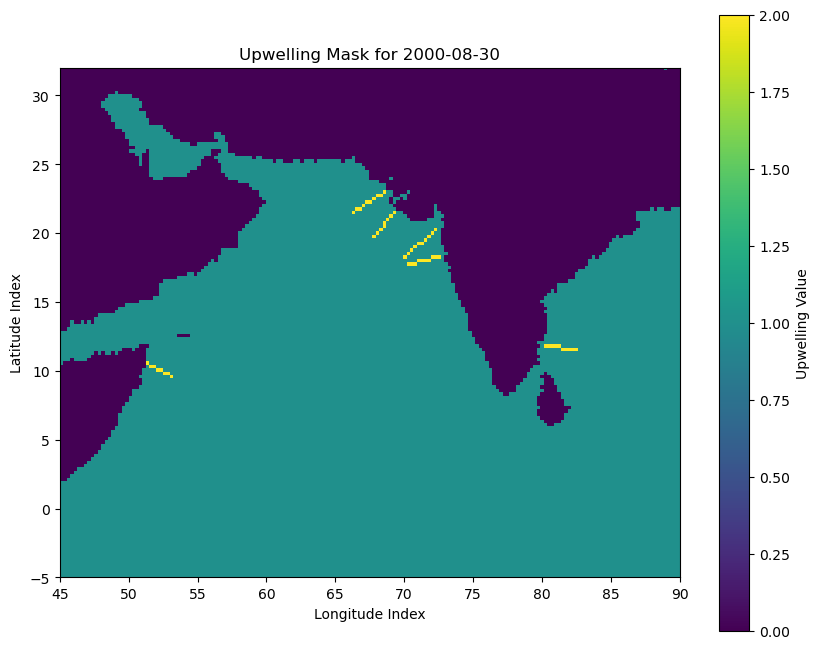

In [32]:
mask_2000_08_30 = mask_dataset['upwelling'].sel(time='2000-09-05').values

plt.figure(figsize=(10, 8))

extent = [lon_dim[0], lon_dim[-1], lat_dim[-1], lat_dim[0]]

plt.imshow(mask_2000_08_30, cmap='viridis', extent=extent, origin='upper')
plt.colorbar(label='Upwelling Value')
plt.title('Upwelling Mask for 2000-08-30')
plt.xlabel('Longitude Index')
plt.ylabel('Latitude Index')
plt.show()

In [9]:
def create_data_map(variable_name, mask_dataset):
    valid_dates = pd.to_datetime(mask_dataset.time.values)
    
    zarr_dates = pd.to_datetime(zarr_new.time.values)
    
    date_to_data_map = {}

    for date in valid_dates:
        if date in zarr_dates:
            data = getattr(zarr_new, variable_name).sel(time=str(date.date())).values
            if not np.all(np.isnan(data)):
                mean_val = np.nanmean(data)
                normalized_day_data = data - mean_val
                normalized_day_data = np.nan_to_num(normalized_day_data, nan=0.0)

                date_to_data_map[date] = normalized_day_data

    return date_to_data_map

data_map = create_data_map('sst', mask_dataset)

In [6]:
filtered_df.iloc[:5]

,time,near_shore_point,off_shore_point,sst_near_shore,sst_off_shore,sst_diff,label
286272,2000-01-01,POINT (51.326946552910215 10.294813025307628),POINT (53.18534593242639 9.306805982572545),298.82303,299.60350,-0.780457,0
286273,2000-01-01,POINT (50.663989599968566 8.412538739972765),POINT (52.56440774778988 7.5580774155731),300.67370,300.65378,0.019928,0
286274,2000-01-01,POINT (49.80726365696406 6.600737914177559),POINT (51.61212074557685 5.608759697278907),300.50558,300.56628,-0.060699,0
286275,2000-01-01,POINT (48.76233593503475 4.892051993872839),POINT (50.3633818641899 3.6323204285740767),300.61942,300.61770,0.001709,0
286276,2000-01-01,POINT (47.50386440681609 3.3328843382296682),POINT (49.005019289066624 1.9928376966654757),300.56165,300.64334,-0.081696,0


In [41]:
import tensorflow as tf
from tensorflow.keras import layers
from keras import models
def build_unet(input_shape):
    inputs = layers.Input(shape=input_shape)
    
    # encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    
    # decoder
    u2 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c2)
    
    # use padding
    u2 = layers.ZeroPadding2D(padding=((0, 1), (0, 1)))(u2)  # adjust the spatial dimensions
    
    c3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u2)
    
    outputs = layers.Conv2D(3, (1, 1), activation='softmax')(c3)
    
    return models.Model(inputs=inputs, outputs=outputs)

In [34]:
from sklearn.model_selection import train_test_split
X_train = []
y_train = []

for date in mask_dataset.time.values:
    X_train.append(data_map[pd.to_datetime(date)])
    y_train.append(mask_dataset['upwelling'].sel(time=date).values)

X_train = np.array(X_train)[:, np.newaxis, :, :]
y_train = np.array(y_train)[:, np.newaxis, :, :]

X_temp, X_test, y_temp, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

X_train = X_train.transpose(0, 2, 3, 1)  # from (batch_size, channels, height, width) to (batch_size, height, width, channels)
X_val = X_val.transpose(0, 2, 3, 1)
X_test = X_test.transpose(0, 2, 3, 1) 

y_train = np.squeeze(y_train, axis=1)
y_val = np.squeeze(y_val, axis=1)
y_test = np.squeeze(y_test, axis=1)

In [42]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10)

input_shape = (X_train.shape[1], X_train.shape[2], 1)
model = build_unet(input_shape=input_shape)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=75, batch_size=8, callbacks=[early_stopping])

Epoch 1/75
576/576 [==============================] - 254s 440ms/step - loss: 0.0581 - accuracy: 0.9820 - val_loss: 0.0152 - val_accuracy: 0.9955
Epoch 2/75
576/576 [==============================] - 253s 439ms/step - loss: 0.0111 - accuracy: 0.9970 - val_loss: 0.0092 - val_accuracy: 0.9977
Epoch 3/75
576/576 [==============================] - 253s 439ms/step - loss: 0.0082 - accuracy: 0.9980 - val_loss: 0.0070 - val_accuracy: 0.9985
Epoch 4/75
576/576 [==============================] - 253s 439ms/step - loss: 0.0066 - accuracy: 0.9986 - val_loss: 0.0061 - val_accuracy: 0.9988
Epoch 5/75
576/576 [==============================] - 253s 440ms/step - loss: 0.0058 - accuracy: 0.9989 - val_loss: 0.0051 - val_accuracy: 0.9990
Epoch 6/75
576/576 [==============================] - 253s 439ms/step - loss: 0.0052 - accuracy: 0.9990 - val_loss: 0.0052 - val_accuracy: 0.9989
Epoch 7/75
576/576 [==============================] - 253s 439ms/step - loss: 0.0048 - accuracy: 0.9991 - val_loss: 0.0047 -

KeyboardInterrupt: 

In [40]:
y_val.shape

(1534, 149, 181)

1/1 [==============================] - 0s 31ms/step


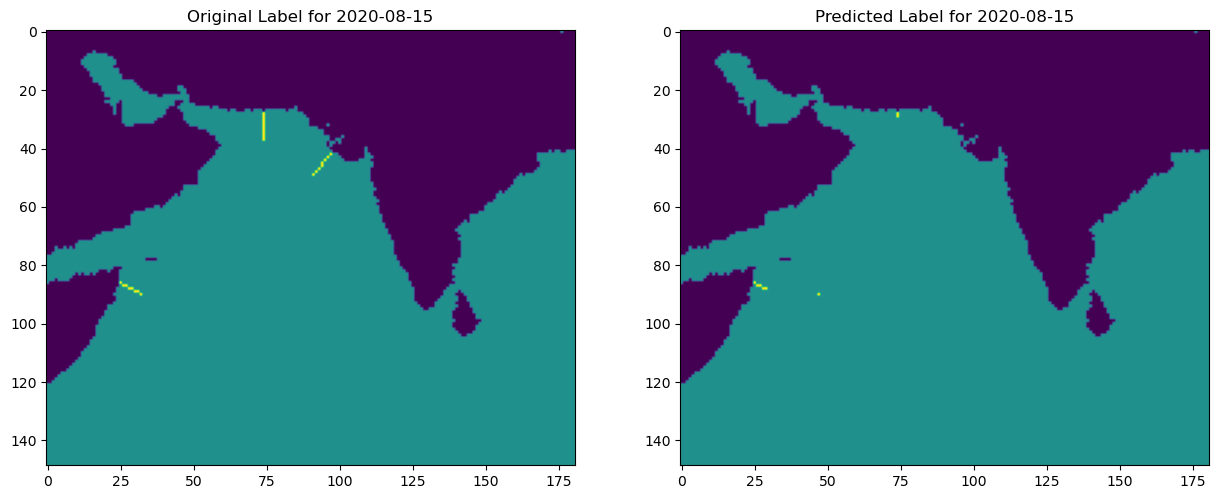

In [56]:
from pandas import Timestamp
sample_input = data_map[Timestamp('2020-09-15 00:00:00')]
sample_label = mask_dataset['upwelling'].sel(time='2020-09-15').values
sample_input_batch = np.expand_dims(sample_input, axis=0)
predicted_output_batch = model.predict(sample_input_batch)
predicted_output = np.squeeze(predicted_output_batch, axis=0)
predicted_class = np.argmax(predicted_output, axis=-1)
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

ax[0].imshow(sample_label, cmap='viridis')
ax[0].set_title('Original Label for 2020-08-15')

ax[1].imshow(predicted_class, cmap='viridis')
ax[1].set_title('Predicted Label for 2020-08-15')

plt.show()